# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 6: Principal Components Analysis (PCA)

**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai<br/>
**Lab Team**: Marios Mattheakis, Hayden Joy, Chris Gumb, and Eleni Kaxiras<br/>
**Authors**: Marios Mattheakis, Hayden Joy 
<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this Lab, our goal is to get you familiarized with Dimensionality Reduction using Principal Components Analysis (PCA). This [medium article](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) was referenced extensively while creating this notebook.

Specifically, we will:

- Define the terms **big data** and **high-dimensionality** 
- Learn what PCA is. What is the motivation to use PCA. 
- Learn about the sklearn PCA library and [its nuances](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- Get familiar with the Linear Algebra of PCA
- Use PCA to **visualize** high-dimensional data in  2-dimensions
- Meet the MNIST handwritten digit dataset (and hopefully stay friends for a while)
- Use PCA in order to **improve model training time** and understand the **speed-accuracy trade-off**
- Discuss the assumptions behind PCA to understand when to use PCA and when not to use it
---

<img src="fig/meme.png" width="400">

---

In [2]:
# Data and stats packages
import numpy as np
import pandas as pd

# Visualization packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# NEW PACKAGES
from sklearn.decomposition import PCA
from time import time


# Other packages
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings("ignore")

# Motivation

Principal Components Analysis helps us deal with high-dimensionality in big-data. 

But first...

<img src="fig/bigdata.png" width="600">

**High-dimensionality** is the case when p is large i.e. there are a lot of predictors. This is sometimes a problem because:

1. Our models may be overfit
2. There may be multi-collinearity
3. Matrices may not be invertible (in the case of OLS)

**Our challenge** is to represent the p dimensions by a smaller number (m) of dimensions without losing much information. Then, we can fit a model using the m predictors, which addresses the three problems listed above. Here's where **PCA** comes into play.

# What is Principal Components Analysis (PCA)?

## A Framework For Dimensionality Reduction

Consider that the data are described by a Linear Regression Model:
$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + \epsilon,
$$
where  $p$ is very large, i.e. **high dimensionality**.


**LASSO for dimensional reduction:**

We can use LASSO: which will drop some of the predictors by forcing $\beta_j=0$. That effectively reduces the dimensions.  Are we happy with that? 
No! Because we totally lose the information kept by the $X_j$ predictors

**PCA for dimensional reduction:**

Considering a new system of coordinates, namely a new set of predictors, denoted by
 $Z_1$, $Z_2$,$\dots$, $Z_m$, where $m \leq p$ and where each $Z_i$ is a linear combination of the original $p$ predictors, $X_1, \dots~ X_p$, thus:

$$
Z_i = \sum_{j=1}^{p} c_{ij} X_i
$$

for some fixed coefficients $c_{ij}$  (PCA will determine them).  For  example:
$$
Z_1 = 3.3 X_1 + 4 X_2 + 0 X_3 + \dots + 1.2 X_p.
$$

Then we can build a linear regression model using the new predictors as follows:
$$
Y = \theta_0 + \theta_1 Z_1 + \theta_2 Z_2 + \dots + \theta_m Z_m + \epsilon
$$

**Notice:** For $m=p$ the number of predictors is the same, hence, we have not lost any information. We just  transform the coordinate systems of the *data-space*. 

**Determine the PCA coefficients $c_{ij}$:**
PCA  identifies a new set of predictors, as linear combinations of the original ones, that captures the *maximum amount* of variance  in the observed data. In other words, PCA determines the $c_{ij}$ such as the data varies most along the new axis $Z_i$, which are called **principal components**. PCA  sorts the axis such as the largest variance goes along $Z_1$, the second largest variance goes to $Z_2$ and so on.

**Comments:**
- The  basic assumption in PCA is that higher variance indicates more importance
- The principal components consist an $m$-dimensional **orthonormal** system of coordinates


<img src="fig/pca.png" width="400">

We see that the "best line" is the one where there is maximal variance along the line. Source [here](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579).

<img src="fig/pca.gif" width="1000">

In principle, we could explore all the rotations, that is, rotating the original coordinate system under all the angles, and find which rotation yields the maximum variance. However, when the dimensionality (p) is large this is an extremely  time consuming and inefficient technique. In that case we may use PCA which is systematic way to find the best rotation or the best coordinate system. 
PCA is a mathematical method based on linear algebra, for more details and rigorous formulation check the advanced section for PCA.


**Have we reduced the dimensions yet?**
No yet... So far we have defined new predictors that linearly depend on the original predictors. Hence, we still have all the information stored in the data. 

**Reducing the dimensions:** Since the $Z_j$ are sorted with respect how much information the *carry*, the larger the $j$ the less important the $Z_j$. Hence, we can keep just a few of the principal components and drop the rest. For instance, keeping only the first two components $(m=2)$, we obtain two predictors that contain information from all the original $p$ predictors. 

How can we choose the m? PCA takes care of that too.

## Applications of PCA

One major application of PCA is to address the issue of high-dimensionality (reduce the number of predictors).

Another major application of PCA is in **visualization**. Specifically, if we have an N-dimensional dataset (N>3), how do we visualize it? 

**One option**: 

<img src="fig/matrix.png" width="400">

**A more practical option**: use PCA to get the top 2-3 principal components and plot these components on 2D or 3D plots.

# PCA for Visualization

Data Source: [MTCars Dataset](https://gist.github.com/seankross/a412dfbd88b3db70b74b)

Here are a few resources that use this dataset and apply PCA for visualization. This notebook references [this PCA tutorial in R](https://www.datacamp.com/community/tutorials/pca-analysis-r), [these lecture notes from CMU](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf), this [blog](https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/), and [this blog](http://setosa.io/ev/principal-component-analysis/) which has some nice visualizations of PCA. 

### Loading in The Cars Dataset and carry out EDA

This dataset consists of data on **32 models** of car, taken from an American motoring magazine (1974 Motor Trend magazine). For each car, you have **11 features**, expressed in varying units (US units), They are as follows ([source](https://www.datacamp.com/community/tutorials/pca-analysis-r)):

- `mpg`: Fuel consumption (Miles per (US) gallon): more powerful and heavier cars tend to consume more fuel.
- `cyl`: Number of cylinders: more powerful cars often have more cylinders
- `disp`: Displacement (cu.in.): the combined volume of the engine's cylinders
- `hp`: Gross horsepower: this is a measure of the power generated by the car
- `drat`: Rear axle ratio: this describes how a turn of the drive shaft corresponds to a turn of the wheels. Higher values will decrease fuel efficiency.
- `wt`: Weight (1000 lbs): pretty self-explanatory!
- `qsec`: 1/4 mile time: the car's speed and acceleration
- `vs`: Engine block: this denotes whether the vehicle's engine is shaped like a "V", or is a more common straight shape.
- `am`: Transmission: this denotes whether the car's transmission is automatic (0) or manual (1).
- `gear`: Number of forward gears: sports cars tend to have more gears.
- `carb`: Number of carburetors: associated with more powerful engines

Note that the units used vary and occupy different scales. 

**Dropping the categorical variables `vs` and `am` and only keeping in the continuous predictors**.

In [3]:
cars_df = pd.read_csv('data/mtcars.csv')
cars_df = cars_df[cars_df.columns.difference(['am', 'vs'])]
cars_df.head()

,carb,cyl,disp,drat,gear,hp,model,mpg,qsec,wt
0,4,6,160.0,3.90,4,110,Mazda RX4,21.0,16.46,2.620
1,4,6,160.0,3.90,4,110,Mazda RX4 Wag,21.0,17.02,2.875
2,1,4,108.0,3.85,4,93,Datsun 710,22.8,18.61,2.320
3,1,6,258.0,3.08,3,110,Hornet 4 Drive,21.4,19.44,3.215
4,2,8,360.0,3.15,3,175,Hornet Sportabout,18.7,17.02,3.440


In [4]:
cars_df.describe()

,carb,cyl,disp,drat,gear,hp,mpg,qsec,wt
count,32.0000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2.8125,6.187500,230.721875,3.596563,3.687500,146.687500,20.090625,17.848750,3.217250
std,1.6152,1.785922,123.938694,0.534679,0.737804,68.562868,6.026948,1.786943,0.978457
min,1.0000,4.000000,71.100000,2.760000,3.000000,52.000000,10.400000,14.500000,1.513000
25%,2.0000,4.000000,120.825000,3.080000,3.000000,96.500000,15.425000,16.892500,2.581250
50%,2.0000,6.000000,196.300000,3.695000,4.000000,123.000000,19.200000,17.710000,3.325000
75%,4.0000,8.000000,326.000000,3.920000,4.000000,180.000000,22.800000,18.900000,3.610000
max,8.0000,8.000000,472.000000,4.930000,5.000000,335.000000,33.900000,22.900000,5.424000


**Our task** is to try to visualize this data in a meaningful way. Obviously we can't make a 9-dimensional plot, but we can try to make several different plots using the `pairplot` function from seaborn.

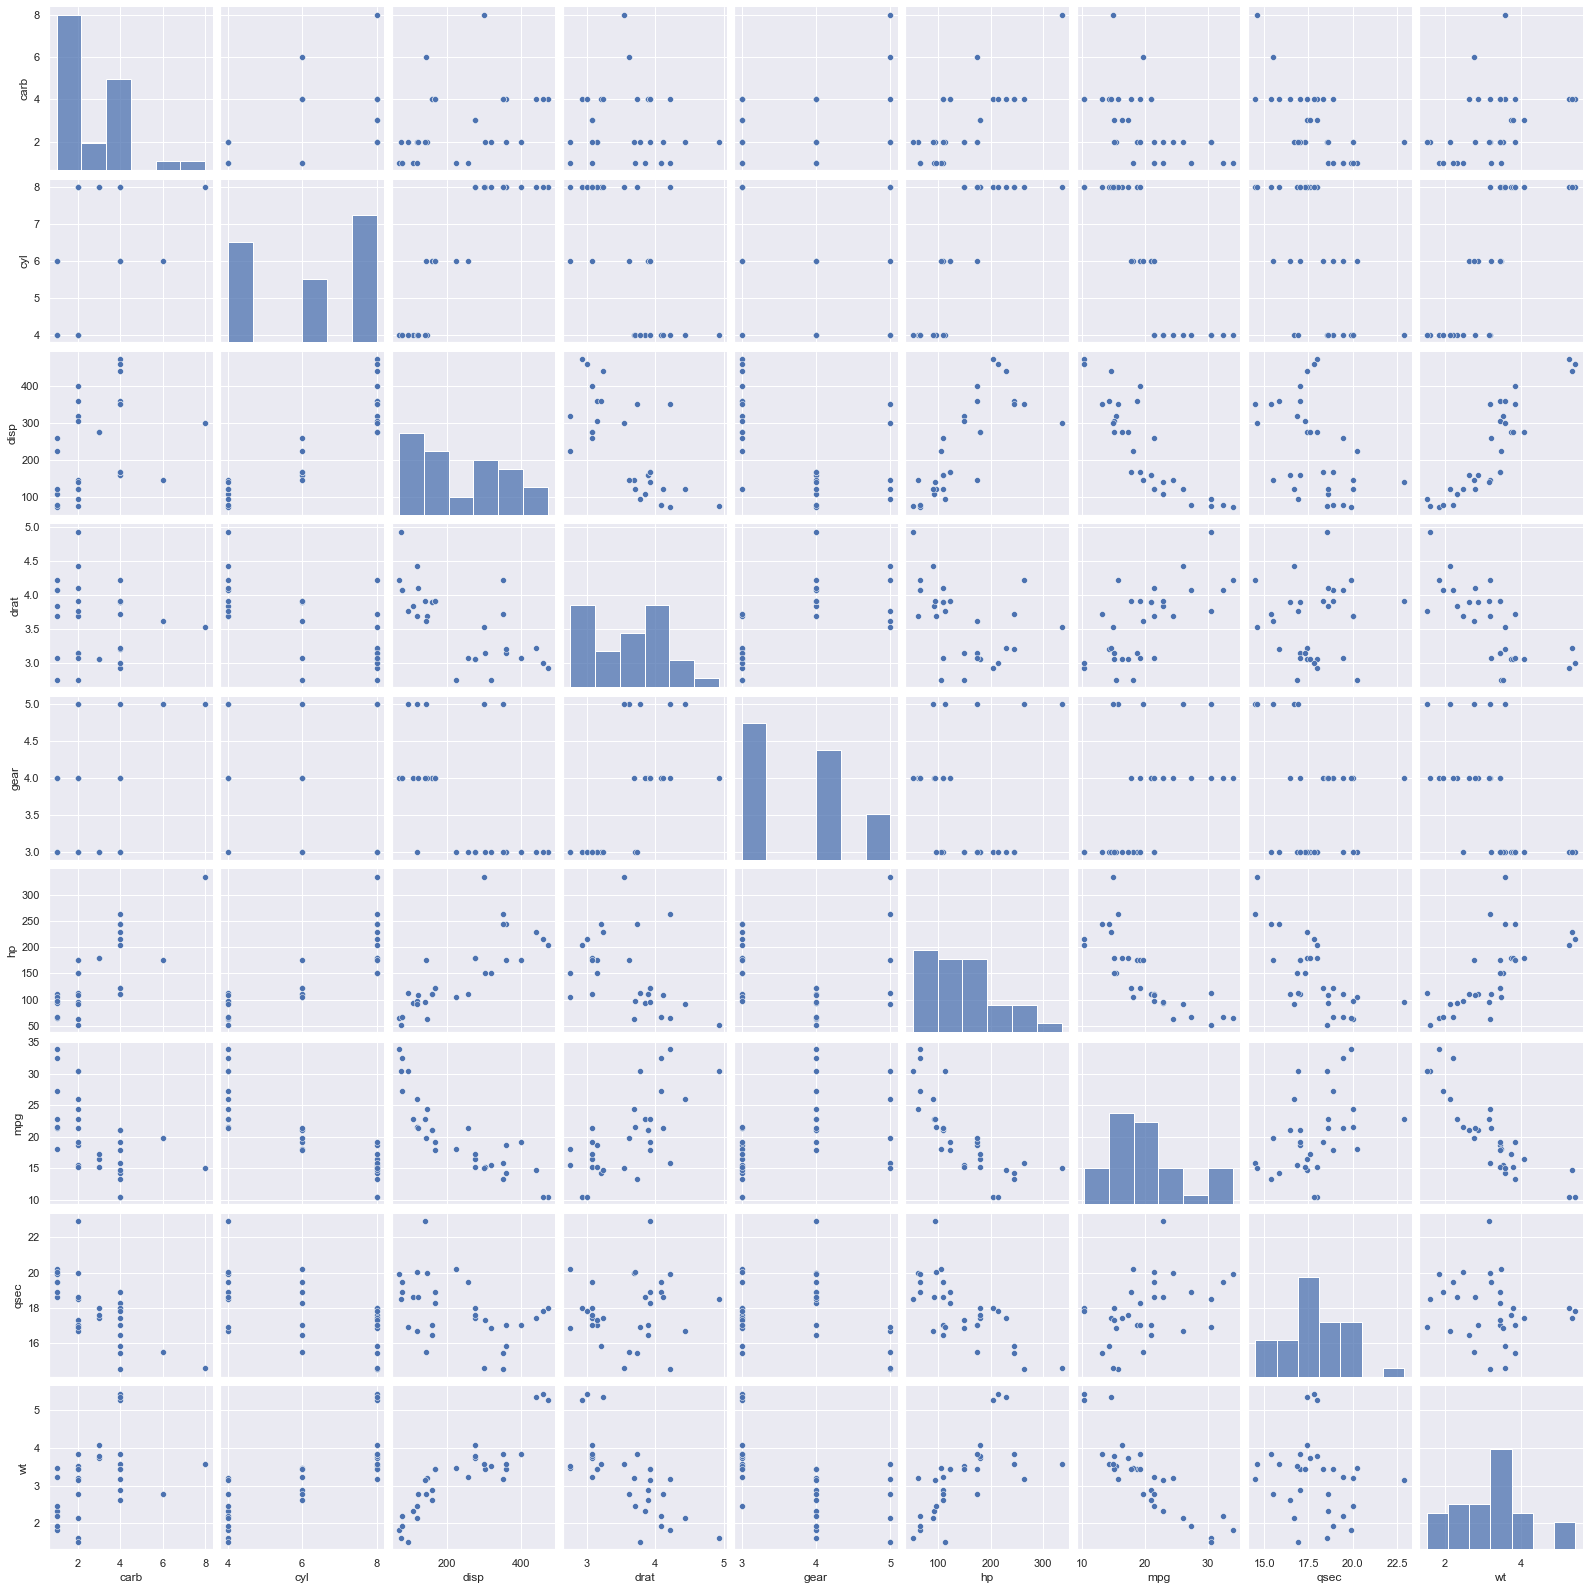

In [5]:
sns.pairplot(cars_df);

But there are numerous variables and numerous more relationships between these variables. We can do better through PCA.

##  Visualization by using PCA

### Standardizing Variables
Standardization is a necessary  step in PCA formulation (more details in advanced section)

In [6]:
# separating the quantitative predictors from the model of the car (a string)
model = cars_df['model']
quant_df = cars_df[cars_df.columns.difference(['model'])]

# Standardization
quant_scaled = StandardScaler().fit_transform(quant_df)
cars_df_scaled = pd.DataFrame(quant_scaled, columns=quant_df.columns)

# We can bring back the model variable, although we do not need it
cars_df_scaled['model'] = cars_df['model']
cars_df_scaled.head()


,carb,cyl,disp,drat,gear,hp,mpg,qsec,wt,model
0,0.746967,-0.106668,-0.579750,0.576594,0.430331,-0.543655,0.153299,-0.789601,-0.620167,Mazda RX4
1,0.746967,-0.106668,-0.579750,0.576594,0.430331,-0.543655,0.153299,-0.471202,-0.355382,Mazda RX4 Wag
2,-1.140108,-1.244457,-1.006026,0.481584,0.430331,-0.795570,0.456737,0.432823,-0.931678,Datsun 710
3,-1.140108,-0.106668,0.223615,-0.981576,-0.946729,-0.543655,0.220730,0.904736,-0.002336,Hornet 4 Drive
4,-0.511083,1.031121,1.059772,-0.848562,-0.946729,0.419550,-0.234427,-0.471202,0.231297,Hornet Sportabout


In [7]:
cars_df_scaled.describe()

,carb,cyl,disp,drat,gear,hp,mpg,qsec,wt
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,32.000000,3.200000e+01,3.200000e+01,3.200000e+01
mean,-2.775558e-17,2.775558e-17,1.665335e-16,-3.053113e-16,-2.775558e-17,0.000000,-4.996004e-16,-1.471046e-15,-4.718448e-16
std,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001,1.016001e+00,1.016001e+00,1.016001e+00
min,-1.140108e+00,-1.244457e+00,-1.308518e+00,-1.589643e+00,-9.467293e-01,-1.403130,-1.633610e+00,-1.903996e+00,-1.769642e+00
25%,-5.110827e-01,-1.244457e+00,-9.008917e-01,-9.815764e-01,-9.467293e-01,-0.743705,-7.865141e-01,-5.436944e-01,-6.604034e-01
50%,-5.110827e-01,-1.066677e-01,-2.821771e-01,1.870518e-01,4.303315e-01,-0.351014,-1.501383e-01,-7.888899e-02,1.118844e-01
75%,7.469671e-01,1.031121e+00,7.810529e-01,6.145986e-01,4.303315e-01,0.493642,4.567366e-01,5.977084e-01,4.078199e-01
max,3.263067e+00,1.031121e+00,1.977904e+00,2.533809e+00,1.807392e+00,2.790515,2.327934e+00,2.871986e+00,2.291423e+00


### Carrying out PCA

[Sklearn PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [8]:
# drop again the model predictor
quant_df = cars_df_scaled[cars_df_scaled.columns.difference(['model'])]

# fitting the PCA object onto our dataframe (excluding the model name column)
pca = PCA().fit(quant_df)

# transforming the dataframe
quant_df_pca = pca.transform(quant_df)

print('Original dimensions:', quant_df.shape)
print('PCA dimensions:     ', quant_df_pca.shape)

Original dimensions: (32, 9)
PCA dimensions:      (32, 9)


Let us examine some of the attributes we obtain from PCA.

1. `explained_variance_`: The amount of variance explained by each of the selected principal components.
2. `explained_variance_ratio_`: Percentage of variance explained by each of the selected principal components. By default, unless `n_components` is  specified  all components will be stored and the sum of the ratios will be  1.0.

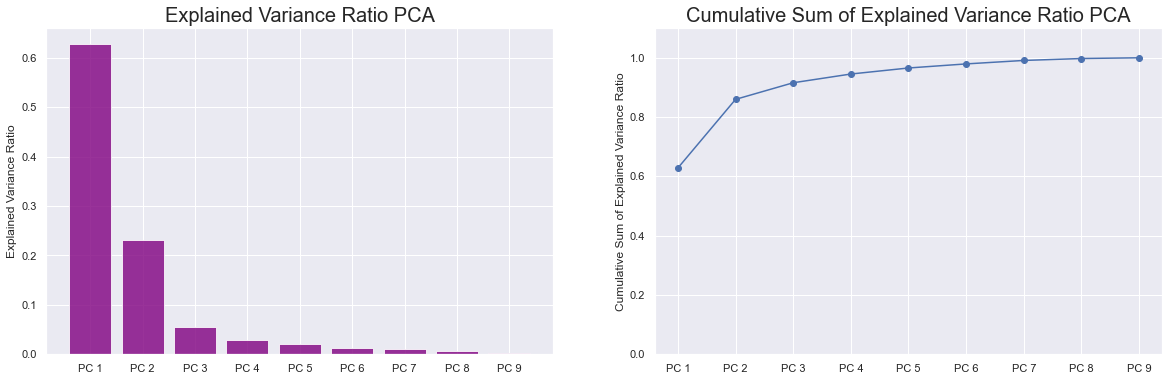

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

We see that over 85% of the variance is explained by the first 2 principal components! 

3. `components_`: This represents the principal components i.e. directions of maximum variance in the data. The components are sorted by `explained_variance_`. 

Let us write the equation for all the principal components using our formulation of the principal components above:

$$
Z_i = \sum_{j=1}^{p} w_{ij} X_i
$$

In [10]:
for i, comp in enumerate(pca.components_):
    expression = 'Z_{} = '.format(i+1)
    for c, x in zip(comp, quant_df.columns):
        if c < 0:
            expression += str(np.round(c,2)) + '*' + x + ' '
        else:
            expression += '+' + str(np.round(c,2)) + '*' + x + ' '
    print(expression + '\n')

Z_1 = -0.24*carb -0.4*cyl -0.4*disp +0.31*drat +0.21*gear -0.37*hp +0.39*mpg +0.22*qsec -0.37*wt 

Z_2 = +0.48*carb +0.02*cyl -0.09*disp +0.34*drat +0.55*gear +0.27*hp +0.03*mpg -0.48*qsec -0.17*wt 

Z_3 = +0.46*carb -0.25*cyl -0.08*disp +0.15*drat +0.21*gear -0.02*hp -0.22*mpg +0.63*qsec +0.45*wt 

Z_4 = -0.21*carb +0.04*cyl +0.34*disp +0.85*drat -0.28*gear +0.07*hp -0.01*mpg -0.03*qsec +0.19*wt 

Z_5 = -0.4*carb -0.12*cyl +0.49*disp -0.16*drat +0.56*gear +0.29*hp +0.32*mpg +0.15*qsec +0.19*wt 

Z_6 = +0.36*carb +0.22*cyl -0.02*disp -0.02*drat -0.32*gear +0.35*hp +0.72*mpg +0.26*qsec -0.08*wt 

Z_7 = -0.21*carb -0.16*cyl -0.18*disp +0.05*drat -0.09*gear +0.7*hp -0.38*mpg +0.28*qsec -0.43*wt 

Z_8 = -0.11*carb +0.81*cyl -0.06*disp +0.14*drat +0.32*gear -0.17*hp -0.12*mpg +0.36*qsec -0.2*wt 

Z_9 = -0.32*carb +0.16*cyl -0.66*disp +0.04*drat +0.05*gear +0.25*hp +0.11*mpg -0.17*qsec +0.57*wt 



Using the printed equations above, we can create vectors showing where each feature has a high value. Let us do this for the **first 2 principal components** (using $v$ to denote a vector): 

$$
\begin{aligned}
v_{carb} = \begin{pmatrix}-0.24 \\ 0.48 \end{pmatrix}, \;
v_{cyl} = \begin{pmatrix}-0.4 \\ 0.02 \end{pmatrix}, \; 
v_{disp} = \begin{pmatrix}-0.4 \\ -0.09 \end{pmatrix}, \\
v_{drat} = \begin{pmatrix}0.31 \\ 0.34 \end{pmatrix}, \;
v_{gear} = \begin{pmatrix}0.21 \\ 0.55 \end{pmatrix}, \;
v_{hp} = \begin{pmatrix}-0.37 \\ 0.27 \end{pmatrix}, \\
v_{mpg} = \begin{pmatrix}0.39 \\ 0.03 \end{pmatrix}, \;
v_{qsec} = \begin{pmatrix}0.22 \\ -0.48 \end{pmatrix}, \;
v_{wt} = \begin{pmatrix}-0.37 \\ -0.17 \end{pmatrix}
\end{aligned}
$$

### Checking if our vectors are orthonormal
Orthonormal vectors are the vectors which are orthogonal (zero dot product) with length equal to one (unit vectors).

#### Orthogonal:
We use the dot product between two vectors to check if the vectors are orthogonal or not. If the dot product is 0, that means that the two vectors are orthogonal. The dot product between two vectors is (geometrically): 

$$
\textbf{a} \cdot \textbf{b} = ||\textbf{a}|| ||\textbf{b}|| \cos(\theta)
$$

Where $\theta$ is the angle between the two vectors and $||\cdot||$ denotes the norm of the vector. Since we assume that the norm of a vector is non-zero, the only way the dot product of two vectors to be zero is when the angle between them is 90 degrees ($\cos(90) = 0$). Thus, the dot product is a way to check if two vectors are perpendicular.

#### Unit vectors
In order to calculate the length $||\textbf{a}||$ of a vector we can take the dot product of a vector with itself, namely
$$ 
||\textbf{a}|| =  \textbf{a}\cdot \textbf{a}
$$

In [11]:
vec1 = pca.components_[0]
vec2 = pca.components_[1]

# print(np.dot(vec1.T, vec2))
print('The dot product between the first two principal components is ',np.round(np.dot(vec1, vec2),5))
print('The length of the first  principal component is ',np.round(np.dot(vec1, vec1),5))

The dot product between the first two principal components is  0.0
The length of the first  principal component is  1.0


We see that the first two principal components are orthogonal and the first principal component is also a unit vector. You can check other pairs of principal components in order to convince yourself that all principal components are always pairwise orthogonal unit vectors.

### Visualizing PCA results

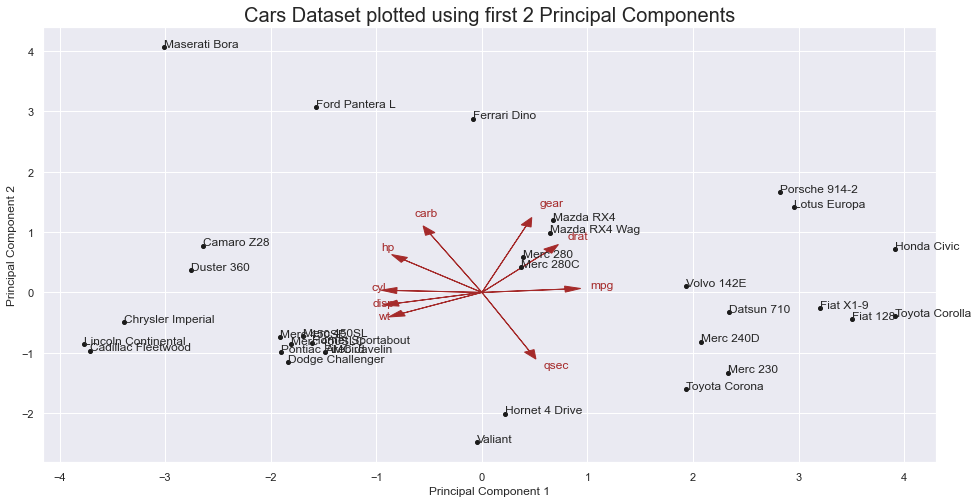

In [12]:
# to plot vectors from the center
vecs = pca.components_[0:10].T *2

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'ok', markersize=4)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads of the original axes projected on the 2D PCA space
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.1)
    s = 1.3
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# annotating text
for i, txt in enumerate(cars_df_scaled['model']):
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), size=12)

**Any patterns of interest?** Let us examine the geography more closely. Source: [this blog](https://www.datacamp.com/community/tutorials/pca-analysis-r). 

In [13]:
country = ["Japan", "US", "EU", "US", "EU", "Japan", "US", "EU", "US", "EU"]
times = [3, 4, 7, 3, 1, 3, 4, 3, 1, 3]
country_list = np.array(sum(([x]*y for x,y in zip(country, times)),[]))

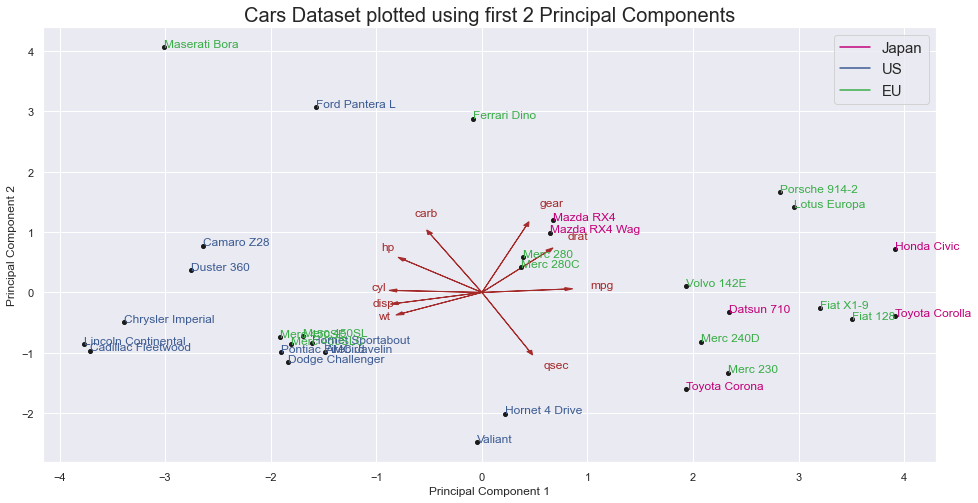

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

# main plot
ax.plot(quant_df_pca[:,0], quant_df_pca[:,1], 'ok', markersize=4)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Cars Dataset plotted using first 2 Principal Components', fontsize=20)

# plotting arrowheads
for i, vec in enumerate(vecs):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.05)
    s = 1.3
    ax.annotate(quant_df.columns[i], (s*vec[0], s*vec[1]), color='brown')

# plotting names
cs = [sns.xkcd_rgb["magenta"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["medium green"]]
colors = {"Japan": cs[0], "US": cs[1], "EU": cs[2]}

# dummy plots to show up in the legend
ax.plot(0,0, color=cs[0], label='Japan')
ax.plot(0,0, color=cs[1], label='US')
ax.plot(0,0, color=cs[2], label='EU')

# plotting text with color
for i, txt in enumerate(cars_df_scaled['model']):
    country = country_list[i]
    ax.annotate(txt, (quant_df_pca[:,0][i], quant_df_pca[:,1][i]), color=colors[country], size=12)
    
ax.legend(fontsize=15);

What patterns do you see now?

For example, looking at the axes, we  see that the American cars are characterized by high values for number of *cyl*, *disp*, and  *wt*. Thus they are more powerful and heavier cars. Japanese cars, on the other hand, are characterized by higher fuel efficieny (*mpg*). European cars are somewhat in the middle and less tightly clustered than either group, but are average more efficient than American cars

**We can draw conclusions visually. Not any modeling so far.**

### Addressing `n_components`

PCA takes in 1 parameter: `n_components`. This defines the number of principal components that PCA will  use. By default, the number of the used principal components is the minimum of the number of rows and the number of columns in the dataset `min(p, n) `. This is the maximum number of dimensions that PCA transform is allowed to use; For more details check the advanced section. 

**Note**: Setting the default parameter for `n_components` and taking the top k principal components is equivalent to setting `n_components=k`. The former is computationally more expensive though. Let's check this.

In [15]:
old_components = pca.components_[0:2]

# doing pca with 2 components
pca2 = PCA(n_components=2).fit(quant_df)

new_components = pca2.components_

# checking equivalence
print(new_components.all() == old_components.all())

True


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 1:</strong> Visualizing high-dimensional data in a 2D plot </div>  



- Perform PCA
- Explore the "Explained Variance Ratio" 
- Keep the first two principal components and visualize the data in this low-dimensional 2D space.
- Explore the "cumulative explained variance ratio"

<img src="fig/iris.png" width="400">


In [26]:
dataset = datasets.load_iris()
print('classes   ', dataset.target_names)
print('predictors', dataset.feature_names)

classes    ['setosa' 'versicolor' 'virginica']
predictors ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [27]:
# pd.DataFrame(dataset.data).describe()

In [28]:
iris_scaled = StandardScaler().fit_transform(dataset.data)

In [29]:
# pd.DataFrame(iris_scaled).describe()

Original dimensions: (150, 4)
PCA dimensions:      (150, 4)


AttributeError: columns

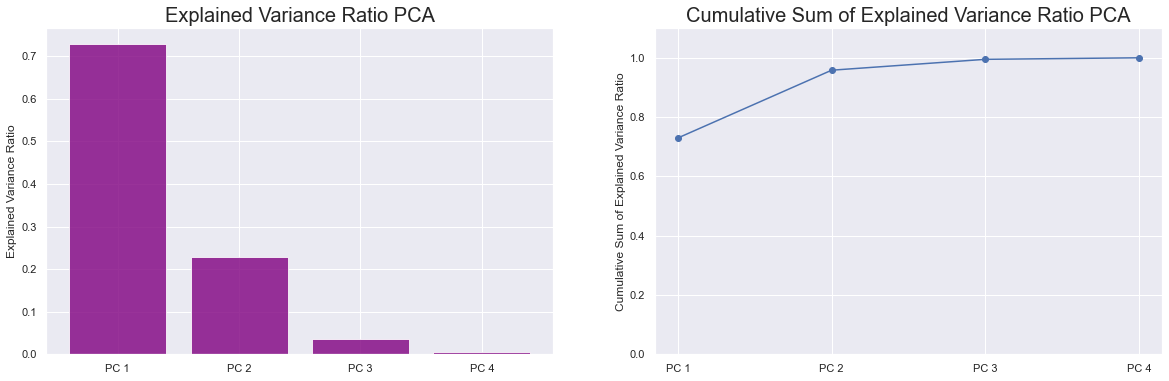

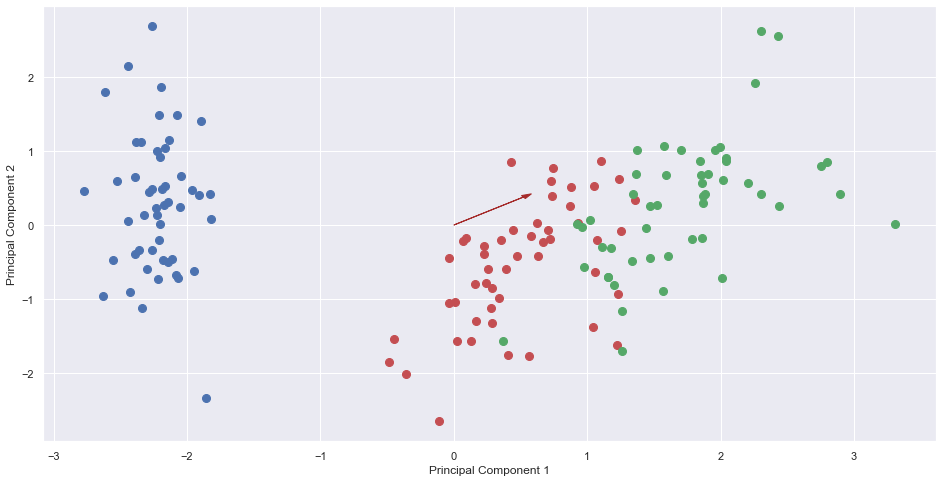

In [34]:
# perform a PCA transform on your dataset
pca_iris = PCA().fit(iris_scaled)
iris_scaled_pca = pca_iris.transform(iris_scaled)

# compare the dimensions of the original and PCA-transformed datasets
print('Original dimensions:', iris_scaled.shape)
print('PCA dimensions:     ', iris_scaled_pca.shape)

## Plot the explained and accumulated explained variance ratios
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca_iris.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax1.set_ylabel('Explained Variance Ratio')

# ratio[0]=0
ratio = pca_iris.explained_variance_ratio_
ax2.plot(np.cumsum(ratio), 'o-')

ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)

ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

#Visualize the pca-transformed data in a 2D space
# Use different color for each label (flower type)
flower_species = dataset.target_names

fig, ax = plt.subplots(figsize=(16,8))
for i in range(dataset.target.shape[0]):
    if dataset.target[i]==0:
        c='b'
    elif dataset.target[i]==1:
        c='r'
    else:
        c='g'
    ax.plot(iris_scaled_pca[i,0], iris_scaled_pca[i,1], 'o', 
            markersize=8, color=c, label = flower_species[dataset.target[i]])
    
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# plotting arrowheads to project the original dimensions/predictors
vecs_iris = pca_iris.components_[0:4].T
for i, vec in enumerate(vecs_iris):
    ax.arrow(0,0,vec[0],vec[1], color='brown', head_width=0.05)
    s = 1.3
    ax.annotate(dataset.columns[i], (s*vec[0], s*vec[1]), color='brown')
    
#remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

**PCA vs manual or Lasso 2D representations:**  Outline the data by using two predictors after applying LASSO or manual selection.

In [ ]:
# Choose two of the predictors to make a 2D plot
# For this dataset the first two predictors are the most important
# print('predictors', dataset.feature_names)

pred_1 = 0
pred_2 = 1

fig, ax = plt.subplots(figsize=(16,8))

for i in range(dataset.target.shape[0]):
    if dataset.target[i]==0:
        c='b'
    elif dataset.target[i]==1:
        c='r'
    else:
        c='g'
        
    ax.plot(iris_scaled[i,pred_1], iris_scaled[i,pred_2], 'o', 
            markersize=8, color=c, label = flower_species[dataset.target[i]])
    
ax.set_xlabel(dataset.feature_names[pred_1])
ax.set_ylabel(dataset.feature_names[pred_2])


Which visualization is more informative? Think about the difference between LASSO and PCA as dimensional reduction methods.

# PCA to speed up classification of Handwritten Digits

This example, using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), was borrowed from this [Towards Data Science blog post](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60). In this example, we will be classifying hand-written digits.

## Data Loading and EDA

#### Loading from Keras datasets

That requires to have installed TensorFlow 2 and Keras. You can verify the installation by displaying the package information as:

In [ ]:
! pip3 show keras

In [ ]:
# we'll use keras a lot more in the last few weeks of the course
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#### Alternatively, just  load the MNIST dataset from the Lab data directory

In [ ]:
# unzip the file
! unzip data/mnist.zip 

#the data are saved in a dictionary with pickle. You can import the data as follows:
import pickle

with open('mnist.pickle', 'rb') as handle:
    mnist_data = pickle.load(handle)
(x_train, y_train), (x_test, y_test) = mnist_data["data"]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Our training set (`x_train`) contains 60000 images of size 28 by 28. Our training labels (`y_train`) are numbers from 0 to 9. Let's examine one of these values below.

The point of this example **is not** to learn modeling with logistic regression, you will learn about it in the following lectures. Here, we want to demonstrate how much PCA accelarates the training 

In [ ]:
print(y_train[0])
fig, ax = plt.subplots()
ax.grid(None)
ax.imshow(x_train[0], cmap='gray');

**Our task** is to classify the test set digits as accurately as possible.

The shape of the training set is $6000 \times 28 \times 28$.  We have not dealt with 3D arrays before. We will deal with images in greater detail (and not only!!!) in the follow-up course, `CS109b`, if you are interested in doing more of this kind of stuff you should take this course. For now, we will **reshape** the array into a 2D array of shape $6000\times 784$.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# check if the shapes are ok
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

## Normalizing Data

Image data is usually between 0 and 255 (0 indicates a black pixel and 255 indicates a white pixel). We can normalize these values by dividing by 255.

Why do we prefer normalization instead of standardization in this case? 

In [ ]:
# checking the min and max of x_train and x_test
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

x_train = (x_train - x_train.min())/(x_train.max() - x_train.min()) 
x_test = (x_test - x_train.min())/(x_train.max() - x_train.min()) 

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

## Modeling using Logistic Regression

**Again:** The point of this example **is not** to learn modeling with logistic regression, you will learn about it in the following lectures. Here, we want to demonstrate how much PCA accelarates the training 

In [ ]:
start = time()
#‘lbfgs’ solver handles multinomial loss in multiclass problems 
logreg_model = LogisticRegression(solver='lbfgs').fit(x_train, y_train)
end = time()

full_logreg_time = end-start
print('Time to fit: {}s'.format(full_logreg_time))

In [ ]:
y_preds_train = logreg_model.predict(x_train)
y_preds_test = logreg_model.predict(x_test)

full_logreg_score_train = accuracy_score(y_train, y_preds_train)
full_logreg_score_test = accuracy_score(y_test, y_preds_test)

# Evaluation
print('Training Set Score: {}'.format(full_logreg_score_train))
print('Test Set Score: {}'.format(full_logreg_score_test))

In [ ]:
# get performance by class 
pd.crosstab(y_test, y_preds_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

We get a high training and test set score but it takes a relatively long time to fit a model. Let us see if we can speed things up when using PCA

## Logistic Regression Model after PCA

In [ ]:
# Do PCA onto our training set and inspect
pca = PCA(n_components=100).fit(x_train)

fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1, ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.plot(range(1,len(ratio)+1), ratio, 'o-')
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_ylabel('Explained Variance Ratio')

ratio = pca.explained_variance_ratio_
ax2.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');

We see that the first 100 principal components hold over 90% of the variance and the first 50 principal components hold over 80% of the variance! We have significantly reduced the dimensionality of our problem! Let us use PCA to find the first 100 principal components of our dataset and transform our `x_train` and `x_test` accordingly.

In [ ]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

print(x_train_pca.shape, x_test_pca.shape)

In [ ]:
start = time()
logreg_model_pca = LogisticRegression(solver='lbfgs').fit(x_train_pca, y_train)
end = time()

print('Time to fit model (100 PCs): {}s'.format(end-start))
print('Time to fit model (full dataset): {}s'.format(full_logreg_time))
print('So to fit the model with the full dataset is about', np.round(full_logreg_time/(end-start),0), ' times slower than using PCA')

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(0, full_logreg_time, width=0.5)
ax.bar(1, end-start, width=0.5)
ax.set_xlabel('Model')
ax.set_xticks([0,1])
ax.set_xticklabels(['Full Dataset', '100 PCs'])
ax.set_ylabel('Time to Fit Model (s)')
ax.set_title('Time taken to fit different models (s)');

**Note:** The time taken to fit our model is considerably smaller! Now let us check our accuracy

In [ ]:
y_preds_train_pca = logreg_model_pca.predict(x_train_pca)
y_preds_test_pca = logreg_model_pca.predict(x_test_pca)

# Evaluation
print('Training Set Score (100 PCs): {}'.format(accuracy_score(y_train, y_preds_train_pca)))
print('Test Set Score (100 PCs): {}\n'.format(accuracy_score(y_test, y_preds_test_pca)))

print('Training Set Score (full dataset): {}'.format(full_logreg_score_train))
print('Test Set Score (full dataset): {}'.format(full_logreg_score_test))

In [ ]:
# get performance by class 
pd.crosstab(y_test, y_preds_test_pca, margins=True, rownames=['Actual'], colnames=['Predicted'])

Not a significant drop in accuracy!! But, since we are losing information by not accounting for all the variance, we are faced with a speed accuracy tradeoff. 
You should explore the case of keeping less principal components.

## Plotting PCA

### Plotting the Reconstructed Image

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1, ax2 = ax.ravel()

ax1.imshow(x_train[0].reshape(28,28), cmap='gray')
ax1.grid(None)
ax1.set_title('Original Image with 784 components')

ax2.imshow(x_train_pca[1].reshape(10,10), cmap='gray')
ax2.grid(None)
ax2.set_title('Image after PCA with 100 components')

fig.tight_layout()

Uhhh... this is terrible. But we can use PCA to carry out an inverse transform in order to get a reconstructed image. Let's try again, using `pca.inverse_transform()`! Source: [this github repo](https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Image_Reconstruction_and_such.ipynb) 

In [ ]:
img_reconstructed = pca.inverse_transform(x_train_pca[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1, ax2 = ax.ravel()

ax1.imshow(x_train[0].reshape(28,28), cmap='gray')
ax1.grid(None)
ax1.set_title('Original Image with 784 components')

ax2.imshow(img_reconstructed.reshape(28,28), cmap='gray')
ax2.grid(None)
ax2.set_title('Reconstructed Image after PCA with 100 components')

fig.tight_layout()

### Plotting all our points on a 2-dimensional plot given by the first 2 principal components of PCA

This [towards data science article](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) has a few similar plots that are pretty cool!

In [ ]:
pca_2 = PCA(n_components=2).fit(x_train)
x_train_2 = pca_2.transform(x_train)
print(x_train_2.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
for i in range(10):
    indices = np.where(y_train == i)[0]
    data = x_train_2[indices]
    ax.plot(data[:,0], data[:,1], 'ob', label='{}'.format(i), alpha=0.5)
ax.set_title('First 2 Principal Components of MNIST Data', fontsize=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend();

Let's add some colors: Different color for each label

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
for i in range(10):
    indices = np.where(y_train == i)[0]
    data = x_train_2[indices]
    ax.plot(data[:,0], data[:,1], 'o', label='{}'.format(i), alpha=0.5)
ax.set_title('First 2 Principal Components of MNIST Data', fontsize=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend();

Any patterns of interest?

# Should I always use PCA?


PCA is **great** for:
1. Speeding up the training of a model without significantly decreasing the predictive ability relative to a model with all p predictors.
2. Visualizing how predictive your features can be of your response, especially in the case of classification.
3. Reducing multicollinearity, and thus potentially improving the computational time required to fit models.
4. Reducing dimensionality in very high dimensional settings.

PCA is **not so good** in certain situations because:
1. Interpretation of coefficients in PCA is completely lost. So do not do PCA if interpretation is important.
3. When the predictors' distribution deviates significantly from a multivariable Normal distribution.
4. When the high variance does not indicate high importance.
5. When the hidden dimensions are not orthonormal.


# Assumptions of PCA

- **Linear change of basis:** PCA is a linear transformation from a Euclidean basis (defined by the original predictors) to an abstract orthonormal basis. Hence, PCA assumes that such a linear change of basis is sufficient for identifying degrees of freedom and conducting dimensionality reduction


- **Mean/variance are sufficient (data are approximately multi-variate gaussian):** 
In applying  PCA to our data, we are only using the means (for standardizing) and the covariance matrix that are associated with our predictors. Thus, PCA  assumes that such statistics are sufficient for describing the distributions of the predictor variables. This is true  only if the predictors are drawn jointly from a multivariable Normal distribution. When the predictor distributions heavily violate this assumption,  PCA components may not be as informative.


- **High variance indicates high importance:** This fundamental assumption is intuitively reasonable, since components corresponding to low variability likely say little about the data, but this is not always true.


- **Principal components are orthogonal:** PCA explicitly assumes that *intrinsic (abstract) dimensions* are orthogonal, which may  not  be true. However, this allowes us to use techniques from linear algebra such as the spectral decomposition and thereby, simplify our calculations.

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2:</strong> Perform classification by using reduced dimensional data-space. </div>  


Specifically compare the classification score when we use: (a) all the predictors; (b) 2 of the original predictors; (c) 2 principal components as predictors.

#### Use all the 4 predictors

In [ ]:
X_train, X_test, y_train_iris, y_test_iris = train_test_split(iris_scaled, dataset.target , test_size=0.4, random_state=42)
print('Shapes for X and y training sets:', X_train.shape, y_train_iris.shape)
print('Shapes for X and y testing sets:', X_test.shape, y_test_iris.shape)

#Training
model_logistic = LogisticRegression(C=100).fit(X_train, y_train_iris)

#Predict
y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)

#Performance Evaluation
train_score = accuracy_score(y_train_iris, y_pred_train)*100
test_score = accuracy_score(y_test_iris, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

#### Use the 2 predictors

In [ ]:
# Choose the first two predictors (sepal length and sepal width)
iris_2predictors = iris_scaled[:,0:2]
X_train, X_test, y_train_iris, y_test_iris = train_test_split(iris_2predictors, dataset.target , test_size=0.4, random_state=42)
print('Shapes for X and y training sets:', X_train.shape, y_train_iris.shape)
print('Shapes for X and y testing sets:', X_test.shape, y_test_iris.shape)

#Training
model_logistic = LogisticRegression(C=100).fit(X_train, y_train_iris)

#Predict
y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train_iris, y_pred_train)*100
test_score = accuracy_score(y_test_iris, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

#### Use the first two  principal componets as predictors

- Perform a PCA transform with 2 principal components
- Use the 2 principal components for a logistic regression
- Print the score for the training and testing sets
- Compare with the previous two cases

In [ ]:
# Performing PCA and asking for 2 principal components (use the scaled data)
pca_iris_2 = 
iris_scaled_pca_2 = 


# Split the dataset using test_size = 0.4
X_train, X_test, y_train_iris, y_test_iris = 

#Training a logistic regression model 
model_logistic = LogisticRegression(C=100).fit( # , #)

#Predict
y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)

#Perfromance Evaluation



----------------
### End of  the Lab
---------------